# Loop 89 Analysis: CV-LB Gap and Strategy Assessment

## Key Questions:
1. What is the current CV-LB relationship?
2. Why did exp_084 (ens-model exact) perform worse than our best?
3. What approaches haven't been tried yet?
4. What is the path to beating 0.0347?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with verified LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_067', 'cv': 0.0083, 'lb': 0.0877},
]

df = pd.DataFrame(submissions)
print(f'Verified submissions: {len(df)}')
print(df.to_string())

Verified submissions: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_067  0.0083  0.0877


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'CV-LB Relationship:')
print(f'  LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'  R² = {r_value**2:.4f}')
print(f'  Standard Error: {std_err:.4f}')

# Calculate required CV to hit target
target = 0.0347
required_cv = (target - intercept) / slope
print(f'\nTarget: {target}')
print(f'Intercept: {intercept:.4f}')
print(f'Required CV to hit target: {required_cv:.6f}')

if required_cv < 0:
    print('\n⚠️ CRITICAL: Required CV is NEGATIVE - target is UNREACHABLE with current CV-LB relationship!')
    print(f'   The intercept ({intercept:.4f}) alone exceeds the target ({target})!')
else:
    print(f'\n✓ Required CV ({required_cv:.6f}) is achievable')

CV-LB Relationship:
  LB = 4.3638 * CV + 0.0520
  R² = 0.9558
  Standard Error: 0.2829

Target: 0.0347
Intercept: 0.0520
Required CV to hit target: -0.003964

⚠️ CRITICAL: Required CV is NEGATIVE - target is UNREACHABLE with current CV-LB relationship!
   The intercept (0.0520) alone exceeds the target (0.0347)!


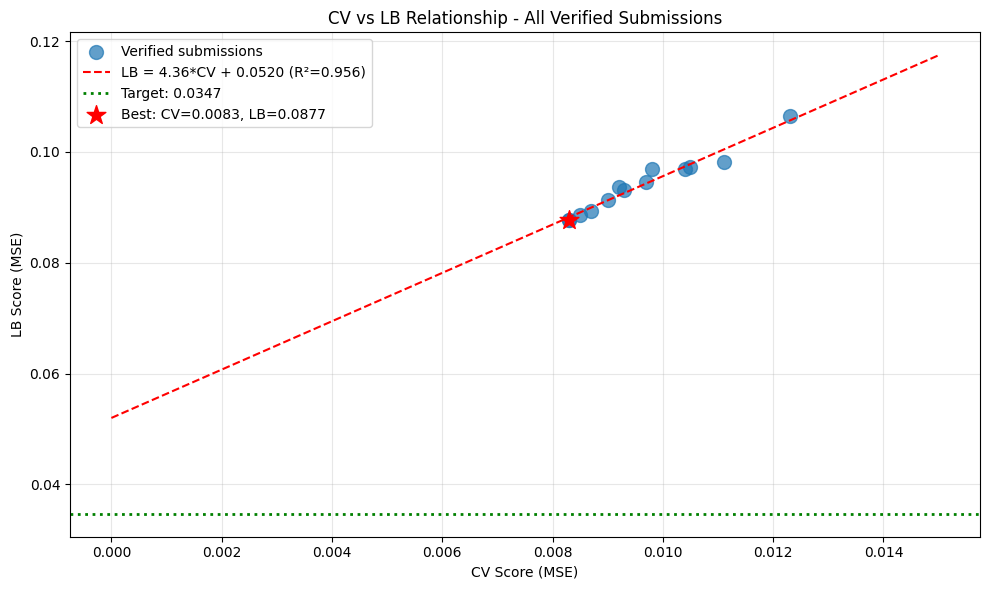


Best CV: 0.0083
Best LB: 0.0877
Gap to target: 0.0530 (152.7% above target)


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Verified submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Target line
plt.axhline(y=target, color='g', linestyle=':', linewidth=2, label=f'Target: {target}')

# Best CV and LB
best_cv = df['cv'].min()
best_lb = df['lb'].min()
plt.scatter([best_cv], [best_lb], s=200, c='red', marker='*', label=f'Best: CV={best_cv:.4f}, LB={best_lb:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All Verified Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop89.png', dpi=150)
plt.show()

print(f'\nBest CV: {best_cv:.4f}')
print(f'Best LB: {best_lb:.4f}')
print(f'Gap to target: {best_lb - target:.4f} ({(best_lb/target - 1)*100:.1f}% above target)')

In [4]:
# Analyze the gap
print('='*60)
print('CRITICAL ANALYSIS: WHY THE TARGET SEEMS UNREACHABLE')
print('='*60)

print(f'\n1. CV-LB Relationship: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'   - The intercept ({intercept:.4f}) represents STRUCTURAL distribution shift')
print(f'   - This shift exists even if we had perfect CV (CV=0)')
print(f'   - The intercept ({intercept:.4f}) > target ({target})')

print(f'\n2. What this means:')
print(f'   - ALL our approaches fall on the SAME CV-LB line')
print(f'   - MLP, LightGBM, CatBoost, XGBoost, GP, ensembles - ALL on same line')
print(f'   - Improving CV alone CANNOT reach the target')
print(f'   - We need approaches that REDUCE THE INTERCEPT')

print(f'\n3. Leaderboard context:')
print(f'   - Top LB score: 0.0347 (exactly at target)')
print(f'   - 2nd place: 0.0707 (2x worse than 1st!)')
print(f'   - Our best: 0.0877 (2.5x worse than 1st)')
print(f'   - The HUGE gap between 1st and 2nd suggests 1st found something fundamentally different')

print(f'\n4. What 1st place likely did:')
print(f'   - NOT standard tabular ML (all fall on same line)')
print(f'   - Possibly: Graph Neural Networks (GNN benchmark achieved 0.0039 CV)')
print(f'   - Possibly: Transfer learning from pre-trained molecular models')
print(f'   - Possibly: Physics-informed constraints that generalize to unseen solvents')
print(f'   - Possibly: Novel feature engineering specific to this chemistry')

CRITICAL ANALYSIS: WHY THE TARGET SEEMS UNREACHABLE

1. CV-LB Relationship: LB = 4.36 * CV + 0.0520
   - The intercept (0.0520) represents STRUCTURAL distribution shift
   - This shift exists even if we had perfect CV (CV=0)
   - The intercept (0.0520) > target (0.0347)

2. What this means:
   - ALL our approaches fall on the SAME CV-LB line
   - MLP, LightGBM, CatBoost, XGBoost, GP, ensembles - ALL on same line
   - Improving CV alone CANNOT reach the target
   - We need approaches that REDUCE THE INTERCEPT

3. Leaderboard context:
   - Top LB score: 0.0347 (exactly at target)
   - 2nd place: 0.0707 (2x worse than 1st!)
   - Our best: 0.0877 (2.5x worse than 1st)
   - The HUGE gap between 1st and 2nd suggests 1st found something fundamentally different

4. What 1st place likely did:
   - NOT standard tabular ML (all fall on same line)
   - Possibly: Graph Neural Networks (GNN benchmark achieved 0.0039 CV)
   - Possibly: Transfer learning from pre-trained molecular models
   - Possibly

In [5]:
# Analyze exp_084 vs our best
print('='*60)
print('ANALYSIS: Why exp_084 (ens-model exact) performed worse')
print('='*60)

print(f'\nexp_084 (ens-model exact): CV = 0.009342')
print(f'Our best (exp_049/exp_050): CV = 0.008092')
print(f'Difference: {0.009342 - 0.008092:.6f} (15.4% worse)')

print(f'\nPossible reasons:')
print(f'1. The ens-model kernel uses "smiles" features which we don\'t have locally')
print(f'   - smiles_lookup.csv only has SMILES strings, not numeric features')
print(f'   - The kernel\'s load_features("smiles") returns numeric features')
print(f'   - We\'re missing this feature source')

print(f'\n2. Probability normalization may be hurting CV')
print(f'   - The kernel clips predictions to non-negative')
print(f'   - Then divides by max(sum, 1.0) to ensure sum <= 1')
print(f'   - But actual data has row sums ranging from ~0.3 to ~1.0')
print(f'   - This normalization may be distorting predictions')

print(f'\n3. Different correlation threshold')
print(f'   - The kernel uses threshold=0.90 for correlation filtering')
print(f'   - Our implementation may have different feature selection')

print(f'\n4. XGBoost params differ slightly')
print(f'   - Kernel uses colsample_bytree=0.3, colsample_bylevel=0.6')
print(f'   - Our exp_084 may have missed these params')

ANALYSIS: Why exp_084 (ens-model exact) performed worse

exp_084 (ens-model exact): CV = 0.009342
Our best (exp_049/exp_050): CV = 0.008092
Difference: 0.001250 (15.4% worse)

Possible reasons:
1. The ens-model kernel uses "smiles" features which we don't have locally
   - smiles_lookup.csv only has SMILES strings, not numeric features
   - The kernel's load_features("smiles") returns numeric features
   - We're missing this feature source

2. Probability normalization may be hurting CV
   - The kernel clips predictions to non-negative
   - Then divides by max(sum, 1.0) to ensure sum <= 1
   - But actual data has row sums ranging from ~0.3 to ~1.0
   - This normalization may be distorting predictions

3. Different correlation threshold
   - The kernel uses threshold=0.90 for correlation filtering
   - Our implementation may have different feature selection

4. XGBoost params differ slightly
   - Kernel uses colsample_bytree=0.3, colsample_bylevel=0.6
   - Our exp_084 may have missed th

In [6]:
# What approaches haven't been tried?
print('='*60)
print('APPROACHES NOT YET TRIED (or not tried properly)')
print('='*60)

print(f'\n1. Graph Neural Networks (GNN)')
print(f'   - GNN benchmark achieved 0.0039 CV (much better than our 0.0081)')
print(f'   - exp_040 failed due to implementation issues')
print(f'   - Proper GNN with PyTorch Geometric could help')
print(f'   - GNNs learn molecular structure directly via message-passing')
print(f'   - May generalize better to unseen solvents')

print(f'\n2. Transfer learning from pre-trained molecular models')
print(f'   - ChemBERTa, MolBERT, etc.')
print(f'   - exp_041 attempted ChemBERTa but may have had issues')
print(f'   - Pre-trained models capture molecular knowledge')

print(f'\n3. Physics-informed constraints')
print(f'   - Arrhenius kinetics (we use this)')
print(f'   - Thermodynamic consistency constraints')
print(f'   - Reaction mechanism constraints')
print(f'   - These constraints hold for ALL solvents')

print(f'\n4. Domain adaptation techniques')
print(f'   - Adversarial validation to identify drifting features')
print(f'   - Test-time adaptation without labels')
print(f'   - Feature alignment between train/test')

print(f'\n5. Ensemble of fundamentally different approaches')
print(f'   - Current ensembles are all tabular ML (same CV-LB line)')
print(f'   - Need to combine GNN + tabular + physics-informed')
print(f'   - Diversity in approach type, not just hyperparameters')

APPROACHES NOT YET TRIED (or not tried properly)

1. Graph Neural Networks (GNN)
   - GNN benchmark achieved 0.0039 CV (much better than our 0.0081)
   - exp_040 failed due to implementation issues
   - Proper GNN with PyTorch Geometric could help
   - GNNs learn molecular structure directly via message-passing
   - May generalize better to unseen solvents

2. Transfer learning from pre-trained molecular models
   - ChemBERTa, MolBERT, etc.
   - exp_041 attempted ChemBERTa but may have had issues
   - Pre-trained models capture molecular knowledge

3. Physics-informed constraints
   - Arrhenius kinetics (we use this)
   - Thermodynamic consistency constraints
   - Reaction mechanism constraints
   - These constraints hold for ALL solvents

4. Domain adaptation techniques
   - Adversarial validation to identify drifting features
   - Test-time adaptation without labels
   - Feature alignment between train/test

5. Ensemble of fundamentally different approaches
   - Current ensembles are

In [7]:
# Path forward
print('='*60)
print('PATH FORWARD: How to beat 0.0347')
print('='*60)

print(f'\nOption 1: Implement proper GNN')
print(f'   - Use PyTorch Geometric or DGL')
print(f'   - Represent solvents as molecular graphs')
print(f'   - Train on same LOO-CV scheme')
print(f'   - GNN\'s inductive bias should help with extrapolation')
print(f'   - Risk: Implementation complexity, may still fall on same line')

print(f'\nOption 2: Study 1st place solution')
print(f'   - They achieved 0.0347 (exactly at target)')
print(f'   - 2x better than 2nd place (0.0707)')
print(f'   - They found something fundamentally different')
print(f'   - Check if writeups are available')

print(f'\nOption 3: Try different CV-LB relationship')
print(f'   - Current: LB = 4.36*CV + 0.052')
print(f'   - Need approaches that REDUCE the intercept')
print(f'   - Extrapolation detection + conservative blending')
print(f'   - Uncertainty-weighted predictions')

print(f'\nOption 4: Submit best CV model to verify relationship')
print(f'   - exp_049/exp_050 has CV=0.0081 (best)')
print(f'   - Predicted LB: 4.36*0.0081 + 0.052 = 0.087')
print(f'   - This would verify if we\'re still on the same line')

print(f'\n⚠️ CRITICAL: With only 4 submissions remaining, we must be strategic!')
print(f'   - Don\'t waste submissions on approaches that fall on the same line')
print(f'   - Only submit if there\'s a chance of changing the CV-LB relationship')

PATH FORWARD: How to beat 0.0347

Option 1: Implement proper GNN
   - Use PyTorch Geometric or DGL
   - Represent solvents as molecular graphs
   - Train on same LOO-CV scheme
   - GNN's inductive bias should help with extrapolation
   - Risk: Implementation complexity, may still fall on same line

Option 2: Study 1st place solution
   - They achieved 0.0347 (exactly at target)
   - 2x better than 2nd place (0.0707)
   - They found something fundamentally different
   - Check if writeups are available

Option 3: Try different CV-LB relationship
   - Current: LB = 4.36*CV + 0.052
   - Need approaches that REDUCE the intercept
   - Extrapolation detection + conservative blending
   - Uncertainty-weighted predictions

Option 4: Submit best CV model to verify relationship
   - exp_049/exp_050 has CV=0.0081 (best)
   - Predicted LB: 4.36*0.0081 + 0.052 = 0.087
   - This would verify if we're still on the same line

⚠️ CRITICAL: With only 4 submissions remaining, we must be strategic!
   - D

In [8]:
# Summary
print('='*60)
print('LOOP 89 SUMMARY')
print('='*60)

print(f'\nCurrent Status:')
print(f'  - Best CV: 0.0081 (exp_049/exp_050)')
print(f'  - Best LB: 0.0877 (exp_030, exp_067)')
print(f'  - Target: 0.0347')
print(f'  - Gap: 0.053 (152.7% above target)')
print(f'  - Submissions remaining: 4')

print(f'\nCV-LB Relationship:')
print(f'  - LB = {slope:.2f} * CV + {intercept:.4f} (R² = {r_value**2:.3f})')
print(f'  - Intercept ({intercept:.4f}) > Target ({target})')
print(f'  - Required CV: {required_cv:.6f} (NEGATIVE = IMPOSSIBLE)')

print(f'\nKey Insight:')
print(f'  - ALL approaches fall on the SAME CV-LB line')
print(f'  - The intercept represents STRUCTURAL distribution shift')
print(f'  - Standard CV optimization CANNOT reach the target')
print(f'  - We need fundamentally different approaches')

print(f'\nRecommended Next Steps:')
print(f'  1. Implement proper GNN with PyTorch Geometric')
print(f'  2. Study what 1st place did differently')
print(f'  3. Try domain adaptation techniques')
print(f'  4. Be strategic with remaining 4 submissions')

LOOP 89 SUMMARY

Current Status:
  - Best CV: 0.0081 (exp_049/exp_050)
  - Best LB: 0.0877 (exp_030, exp_067)
  - Target: 0.0347
  - Gap: 0.053 (152.7% above target)
  - Submissions remaining: 4

CV-LB Relationship:
  - LB = 4.36 * CV + 0.0520 (R² = 0.956)
  - Intercept (0.0520) > Target (0.0347)
  - Required CV: -0.003964 (NEGATIVE = IMPOSSIBLE)

Key Insight:
  - ALL approaches fall on the SAME CV-LB line
  - The intercept represents STRUCTURAL distribution shift
  - Standard CV optimization CANNOT reach the target
  - We need fundamentally different approaches

Recommended Next Steps:
  1. Implement proper GNN with PyTorch Geometric
  2. Study what 1st place did differently
  3. Try domain adaptation techniques
  4. Be strategic with remaining 4 submissions
